In [42]:
%matplotlib inline

### os 
import os 
import sys

### datetimes 
from datetime import datetime, timedelta

### scipy 
import numpy as np 
import pandas as pd
import xarray as xr

### plotting 
from matplotlib import pyplot as plt
import seaborn as sns

In [43]:
import pathlib

HOME = pathlib.Path.home()
CWD = pathlib.Path.cwd() 

In [3]:
import climpred

In [4]:
dpath = pathlib.Path('/media/nicolasf/END19101/data/climate_indices')

In [5]:
SAM_obs = pd.read_csv(dpath.joinpath("SAM_ERA5/SAM_ERA5.csv"), index_col=0, parse_dates=True) 

In [8]:
SAM_obs = SAM_obs.to_xarray()

In [11]:
SAM_ecmwf = pd.read_csv(dpath.joinpath("SAM_GCM/SAM_ECMWF.csv"), index_col=0, parse_dates=True, header=[0,1]) 

In [18]:
SAM_ecmwf.values

array([[ 1.58696   ,  1.8702365 , -0.45045704,  2.2068644 , -1.3223414 ,
        -2.1245043 ],
       [ 1.586646  ,  1.5783265 , -0.71524054,  0.04808416, -0.02863207,
        -2.6089334 ],
       [-3.983094  , -1.1963828 , -0.9194294 ,  0.07350317,  2.8611927 ,
         0.5394476 ],
       ...,
       [ 0.09192917, -0.9845137 ,  1.048517  ,  0.19593316,  0.05989015,
         2.6725166 ],
       [-6.6182423 , -3.650652  ,  0.0184868 ,  1.6268547 ,  1.0807596 ,
        -0.7487736 ],
       [-3.924686  , -2.2370262 , -0.92530715,  0.14487787,  1.2972898 ,
         2.2483754 ]])

In [19]:
SAM_ecmwf_xr = {}

In [20]:
SAM_ecmwf_xr['init'] = (('init'), SAM_ecmwf.index.to_pydatetime()) 

In [21]:
SAM_ecmwf_xr['lead'] = (('lead'), np.arange(6))

In [22]:
SAM_ecmwf_xr['SAM'] = (('init','lead'), SAM_ecmwf.values)

In [23]:
SAM_ecmwf_xr = xr.Dataset(SAM_ecmwf_xr)

In [27]:
SAM_ecmwf_xr['lead'].attrs = {'units':'months'}

In [28]:
hindcast = climpred.HindcastEnsemble(SAM_ecmwf_xr)

In [31]:
hindcast = hindcast.add_observations(SAM_obs)

In [35]:
acc = hindcast.verify(metric='pearson_r', comparison='e2o', dim='init', alignment='maximize', reference='persistence')

In [33]:
skill

<xarray.Dataset>
Dimensions:  (lead: 6)
Coordinates:
  * lead     (lead) int64 0 1 2 3 4 5
    skill    <U11 'initialized'
Data variables:
    SAM      (lead) float64 0.7128 0.3398 0.2546 0.2302 0.1941 0.1888

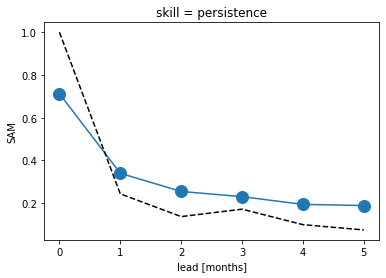

In [36]:
acc.sel(skill='initialized').SAM.plot(marker='o', markersize=12)
acc.sel(skill='persistence').SAM.plot(color='k', linestyle='--')

In [38]:
result = []
for label, group in SAM_ecmwf_xr.groupby('init.month'):
    hindcast = climpred.HindcastEnsemble(group)
    hindcast = hindcast.add_observations(SAM_obs)
    hindcast.load()
    skill = hindcast.verify(metric='acc', comparison='e2o', dim='init', alignment='maximize')
    result.append(skill)

result = xr.concat(result, dim='month')
result['month'] = np.arange(12) + 1

In [39]:
result

<xarray.Dataset>
Dimensions:  (lead: 6, month: 12)
Coordinates:
  * lead     (lead) int64 0 1 2 3 4 5
    skill    <U11 'initialized'
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    SAM      (month, lead) float64 0.7033 0.4437 0.105 ... 0.01729 0.04995

In [40]:
result = result.to_dataframe()['SAM'].unstack()

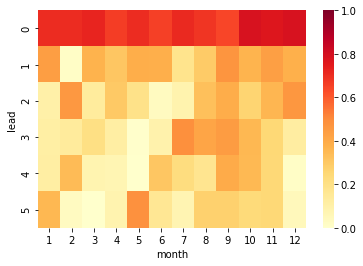

In [45]:
ax = sns.heatmap(result, cmap='YlOrRd', vmin=0, vmax=1)